In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 设置合成数据的特征
total_size = 1000000

def gen_data(size=total_size):
    """ 按照上图生成合成序列数据
    
    Arguments:
        size: input 和 output 序列的总长度
    
    Returns:
        X, Y: input 和 output 序列，rank-1的numpy array （即，vector)
    """
    
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)


def gen_batch(raw_data, batch_size, num_steps):
    """产生minibatch数据
    
    Arguments:
        raw_data: 所有的数据， (input, output) tuple
        batch_size: 一个minibatch包含的样本数量；每个样本是一个sequence
        num_step: 每个sequence样本的长度
        
    Returns:
        一个generator，在一个tuple里面包含一个minibatch的输入，输出序列
    """
    
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps, batch_size):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)


def rnn_model(num_steps, batch_size, state_size):
    """ Build the rnn model computational graph.
    """
    # Placeholders
    graph = tf.Graph()
    with graph.as_default():

        x = tf.placeholder(tf.int32, [None, num_steps],
                           name='input_placeholder')
        y = tf.placeholder(tf.int32, [None, num_steps],
                           name='labels_placeholder')


        # RNN Inputs， 将前面定义的placeholder输入到RNN cells
        num_classes = 2
        x_one_hot = tf.one_hot(x, num_classes) # [batch_size, num_steps，num_classes = 2]
        rnn_inputs = tf.unstack(x_one_hot, axis=1) # [ num_steps, [batch_size, num_classes]]


        # 手动实现 rnn_cell

        with tf.variable_scope('rnn_cell'):
            W = tf.get_variable('W', [num_classes + state_size, state_size], 
                               initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.01))
            b = tf.get_variable('b', [state_size],
                                initializer = tf.constant_initializer(0.0))
        def rnn_cell(rnn_input, state):
            with tf.variable_scope('rnn_cell', reuse=True):
                W = tf.get_variable('W', [num_classes + state_size, state_size])
                b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
            return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)


        # 对每个time frame应用rnn
        rnn_outputs = []
        init_state = tf.zeros([batch_size, state_size])

        state = init_state
        for rnn_input in rnn_inputs:
            state = rnn_cell(rnn_input, state)
            rnn_outputs.append(state)

        final_state = rnn_outputs[-1]


        # 从每个 time frame 的 hidden state
        # 映射到每个 time frame 的最终 output（prediction）；
        # 和CBOW或者SKIP-GRAM的最上一层相同

        with tf.variable_scope('softmax'):
            W = tf.get_variable('W', [state_size, num_classes])
            b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
        logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
        predictions = [tf.nn.softmax(logit) for logit in logits]

        # 计算损失函数
        y_as_list = tf.unstack(y, num=num_steps, axis=1)
        losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for
                  logit, label in zip(logits, y_as_list)]
        total_loss = tf.reduce_mean(losses)

        # 定义优化器
        learning_rate = 0.1
        train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

    return graph, losses, total_loss, final_state, train_step, x, y, init_state
    #return graph


def train_rnn(gen_epochs, num_steps = 10, batch_size = 32, state_size = 16):
    
    num_epochs = 5
    verbose = False

    graph, losses, total_loss, final_state, train_step, x, y, init_state = rnn_model(
            num_steps, batch_size, state_size)
    with tf.Session(graph=graph) as sess:
        
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size)):
            training_loss = 0
            #training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                training_state = np.zeros((batch_size, state_size))
                tr_losses, training_loss_, training_state, _ = sess.run(
                    [losses,
                     total_loss,
                     final_state,
                     train_step],
                    feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 500 == 0 and step > 0:
                    if verbose:
                        print("At step %d, average loss of last 500 steps are %f\n"
                              % (step, training_loss/500.0))
                    training_losses.append(training_loss/500.0)
                    training_loss = 0
    return training_losses

In [ ]:
training_losses_3_16 = train_rnn(gen_epochs, num_steps = 3, batch_size = 32, state_size = 16)
training_losses_3_4 = train_rnn(gen_epochs, num_steps = 3, batch_size = 32, state_size = 4)

training_losses_4_16 = train_rnn(gen_epochs, num_steps = 4, batch_size = 32, state_size = 16)
training_losses_4_4 = train_rnn(gen_epochs, num_steps = 4, batch_size = 32, state_size = 4)

training_losses_8_16 = train_rnn(gen_epochs, num_steps = 8, batch_size = 32, state_size = 16)
training_losses_8_4 = train_rnn(gen_epochs, num_steps = 8, batch_size = 32, state_size = 4)

training_losses_9_16 = train_rnn(gen_epochs, num_steps = 9, batch_size = 32, state_size = 16)
training_losses_9_4 = train_rnn(gen_epochs, num_steps = 9, batch_size = 32, state_size = 4)

training_losses_10_16 = train_rnn(gen_epochs, num_steps = 10, batch_size = 32, state_size = 16)
training_losses_10_4 = train_rnn(gen_epochs, num_steps = 10, batch_size = 32, state_size = 4)

training_losses_20_16 = train_rnn(gen_epochs, num_steps = 20, batch_size = 32, state_size = 16)
training_losses_20_4 = train_rnn(gen_epochs, num_steps = 20, batch_size = 32, state_size = 4)

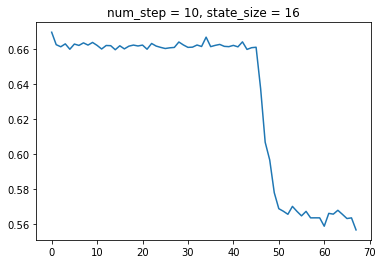

In [79]:
plt.plot(training_losses_9_16)
plt.title('num_step = 10, state_size = 16')
plt.show()

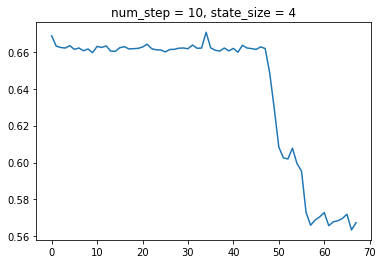

In [80]:
plt.plot(training_losses_9_4)
plt.title('num_step = 10, state_size = 4')
plt.show()

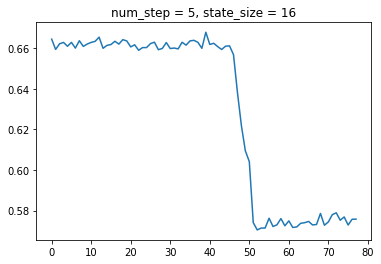

In [81]:
plt.plot(training_losses_8_16)
plt.title('num_step = 5, state_size = 16')
plt.show()

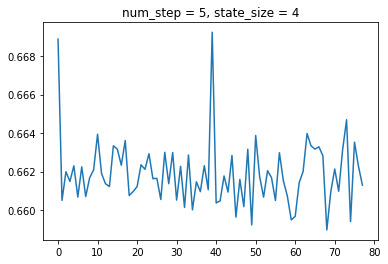

In [84]:
plt.plot(training_losses_8_4)
plt.title('num_step = 5, state_size = 4')
plt.show()

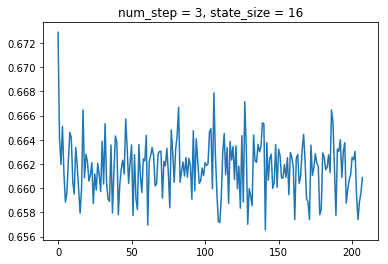

In [85]:
plt.plot(training_losses_3_16)
plt.title('num_step = 3, state_size = 16')
plt.show()

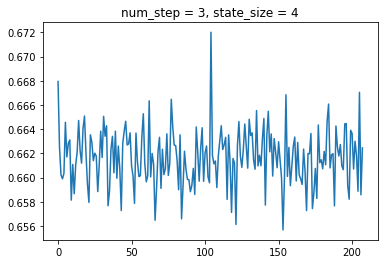

In [86]:
plt.plot(training_losses_3_4)
plt.title('num_step = 3, state_size = 4')
plt.show()